In [1]:
import cv2
import numpy as np
import imutils
from matplotlib import pyplot as plt

class ImageIdentifier:
    def __init__(self, name):
        self.name = name
        self.image = imutils.resize(cv2.imread(name), width=600)
        self.hsv = cv2.cvtColor(self.image, cv2.COLOR_BGR2HSV)
        self.mask = None
        self.outline_image = None
        self.image_identificated = None
        self.img_blurred = None
        self.harris = None
        self.sift = None
        self.low = None
        self.high = None

    def set_mask(self, low, high):
        self.low = low
        self.high = high
        low_arr = np.array(low)
        high_arr = np.array(high)
        self.mask = cv2.inRange(self.hsv, low_arr, high_arr)
        img_bit = cv2.bitwise_and(self.image, self.image, mask=self.mask)
        self.img_blurred = cv2.medianBlur(img_bit, 5)


    def outline(self, outline_colour=(102, 255, 178)):
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.dilate(self.mask, kernel, iterations=2)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        self.outline_image = self.image.copy()
        cv2.drawContours(self.outline_image, contours, -1, outline_colour, 2)

    def identificate(self, outline_color=(102, 255, 178), text_color=(102, 255, 178)):
        kernel = np.ones((5, 5), np.uint8)
        connected_mask = cv2.dilate(self.mask, kernel, iterations=2)
        find_outline, _ = cv2.findContours(connected_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        areas = [cv2.contourArea(outline) for outline in find_outline]
        min_area_percent = np.quantile(areas, 0.95)

        self.image_identificated = self.image.copy()

        number_of_the_place = 0
        for outline in find_outline:
            if cv2.contourArea(outline) > min_area_percent:
                number_of_the_place += 1
                cv2.drawContours(self.image_identificated, [outline], -1, outline_color, 2)

                moments = cv2.moments(outline)
                center_x = int(moments['m10'] / moments['m00'])
                center_y = int(moments['m01'] / moments['m00'])
                text = f'Place {number_of_the_place}'
                font = cv2.FONT_HERSHEY_DUPLEX

                size, _ = cv2.getTextSize(text, font, 0.5, 2)
                offset_x = center_x - int(size[0] / 2)
                offset_y = center_y + int(size[1] / 2)
                cv2.putText(self.image_identificated, text, (offset_x, offset_y), font, 0.5, text_color, 2)

    def extract_fragment_rgb(self, x1, x2, y1, y2, show_fragment=True):
        fragment = self.image[y1:y2, x1:x2]

        if show_fragment:
            plt.imshow(fragment)
            plt.title(f"Image fragment in range X: {x1}-{x2}, Y: {y1}-{y2}")
            plt.show()

        fragment_rgb = cv2.cvtColor(fragment, cv2.COLOR_BGR2RGB)
        avg_color_per_row = np.average(fragment_rgb, axis=0)
        avg_color = np.average(avg_color_per_row, axis=0)
        return avg_color

    def show_image(self):
        plt.imshow(self.image)
        plt.title(f"{self.name}")
        plt.show()

    def show_outlined_image(self):
        plt.imshow(self.outline_image)
        plt.title(f"Outlined image {self.name}")
        plt.show()

    def show_harris(self):
        plt.imshow(self.harris)
        plt.title(f"Harris Detector {self.name}")
        plt.show()

    def show_sift(self):
        plt.imshow(self.sift)
        plt.title(f"SIFT Detector {self.name}")
        plt.show()

    def show_identified_image(self):
        plt.imshow(self.image_identificated)
        plt.title(f"Identificated places {self.name}")
        plt.show()

    def show_blurred_image(self):
        plt.imshow(self.img_blurred)
        plt.title(f"Blurred image {self.name}")
        plt.show()

    def show_all(self, mask_l, mask_h):
        self.show_image()
        self.set_mask(mask_l, mask_h)
        self.outline()
        self.show_blurred_image()
        self.identificate()
        self.harris_corner_detector()
        self.sift_descriptors_on_harris()
        self.show_outlined_image()
        self.show_identified_image()
        self.show_harris()
        self.show_sift()

    def harris_corner_detector(self):
        image = self.img_blurred.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray = np.float32(gray)
        harris_corner = cv2.cornerHarris(gray, 2, 3, 0.04)
        harris_corner = cv2.dilate(harris_corner, None)
        image[harris_corner > 0.01 * harris_corner.max()] = [0, 0, 255]
        self.harris = image

    def sift_descriptors_on_harris(self):
        def harris(img):
            grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            grey = np.float32(grey)
            harris_corner = cv2.cornerHarris(grey, 2, 3, 0.04)
            result = img.copy()
            result[harris_corner > 0.01 * harris_corner.max()] = [0, 0, 255]
            key_points = np.argwhere(harris_corner > 0.01 * harris_corner.max())
            key_points = [cv2.KeyPoint(float(x[1]), float(x[0]), 13) for x in key_points]
            return (key_points, result)

        image = self.img_blurred.copy()
        key_points, image = harris(image)
        sift = cv2.SIFT_create()
        sift.compute(image, key_points)
        image = cv2.drawKeypoints(image, key_points, image)
        self.sift = image

    def feature_matching_sift(self, other_image_path, show_second_image = True):
        img1 = self.img_blurred.copy()
        img2 = ImageIdentifier(other_image_path)
        if show_second_image:
            img2.show_all(self.low, self.high)
        else:
            img2.set_mask(self.low, self.high)
        img2 = img2.img_blurred
        
        sift = cv2.SIFT_create()
        key_points_1, des_1 = sift.detectAndCompute(img1, None)
        key_points_2, des_2 = sift.detectAndCompute(img2, None)

        KDTREE = 1
        index_params = dict(algorithm=KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des_1, des_2, k=2)

        number_of_descriptors_img1 = len(des_1)
        number_of_descriptors_img2 = len(des_2)

        same_descriptors = 0
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                same_descriptors += 1

        print(f'The number of descriptors in the first image: {number_of_descriptors_img1}')
        print(f'The number of descriptors in the second image: {number_of_descriptors_img2}')
        print(f'The number of matches: {same_descriptors}')

        min_total_descriptors = min(number_of_descriptors_img1, number_of_descriptors_img2)
        similarity_percentage = round(min(100 * (same_descriptors / min_total_descriptors), 100), 3)
        belive_interval = round(min(100 * (same_descriptors / min_total_descriptors) / 0.15, 100), 3)
        print(f'Percentage of identity: {similarity_percentage}%')
        print(f'Confidence percentage: {belive_interval}%')
        if belive_interval > 50:
            print(f"Conclusion: the objects are identical")
        else:
            print(f"Objects are not identical")

        matchesMask = [[0, 0] for _ in range(len(matches))]
        for i, (m, n) in enumerate(matches):
            if m.distance < 0.7 * n.distance:
                matchesMask[i] = [1, 0]

        draw_params = dict(matchColor=(0, 255, 0),
                           singlePointColor=(255, 0, 0),
                           matchesMask=matchesMask,
                           flags=cv2.DrawMatchesFlags_DEFAULT)

        img3 = cv2.drawMatchesKnn(img1, key_points_1, img2, key_points_2, matches, None, **draw_params)
        height, width, _ = img3.shape
        img_with_line = cv2.line(img3, (width // 2, 0), (width // 2, height), (255, 255, 255), 2)
        plt.imshow(img_with_line)
        plt.show()


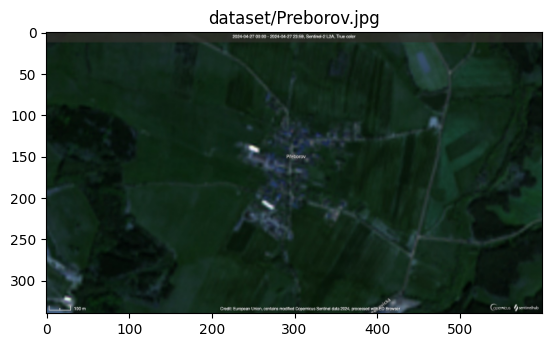

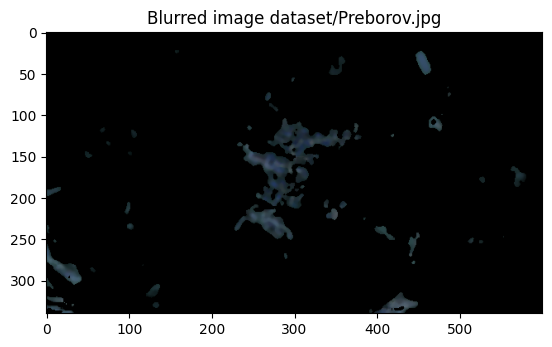

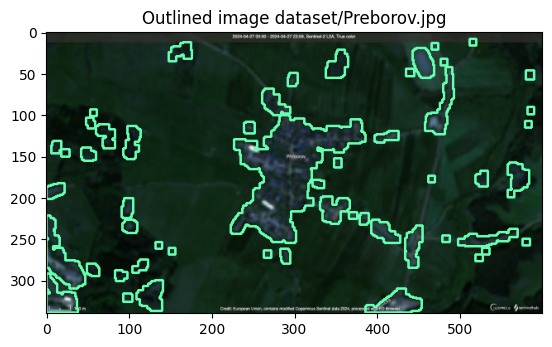

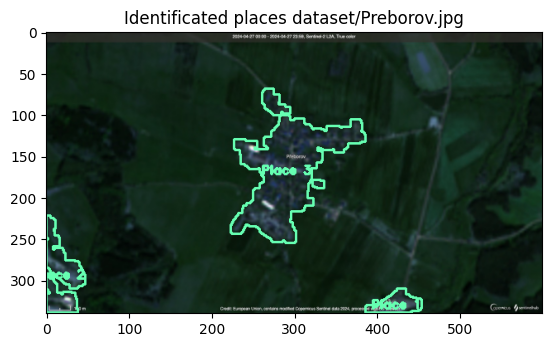

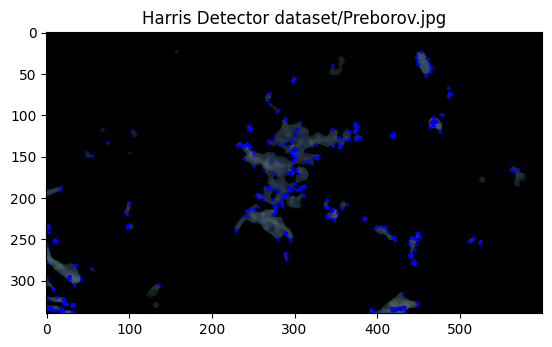

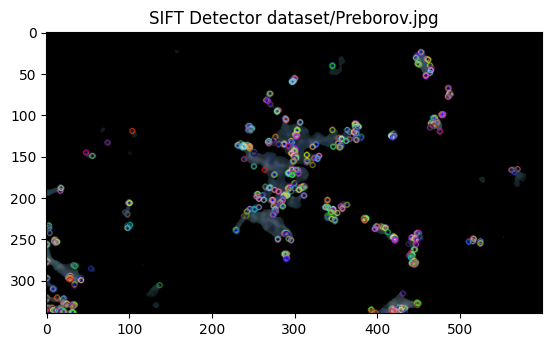

Image comparison


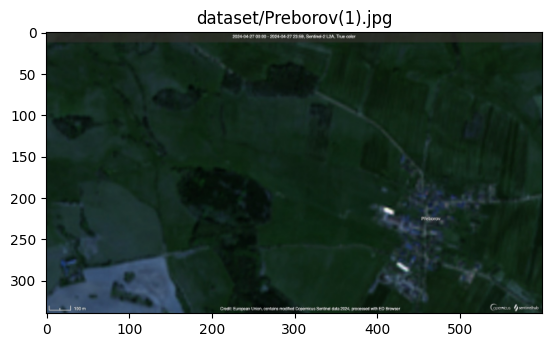

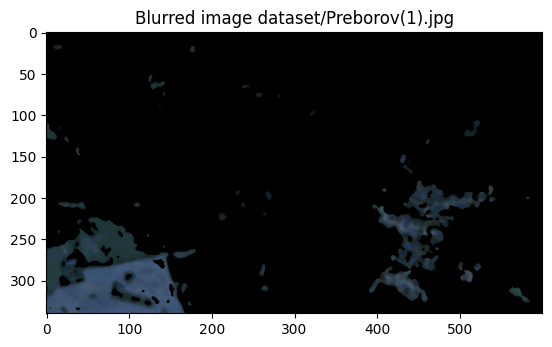

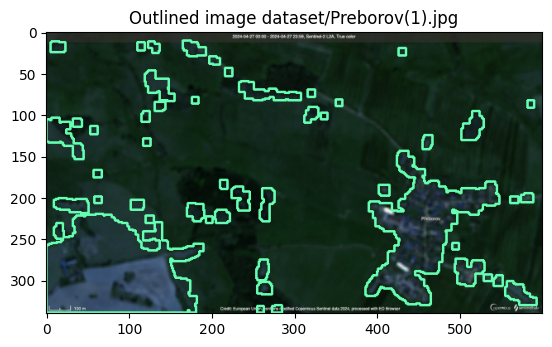

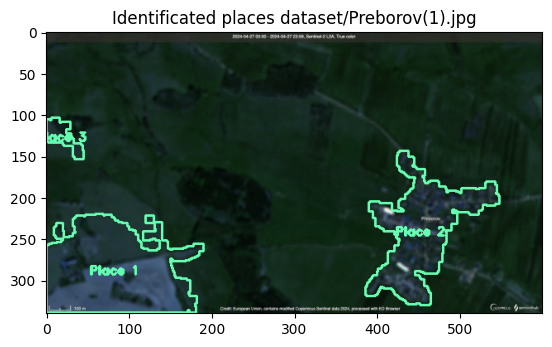

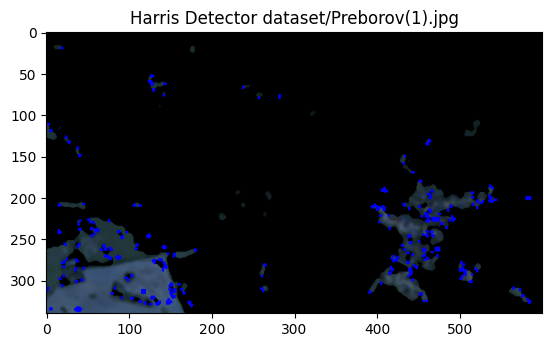

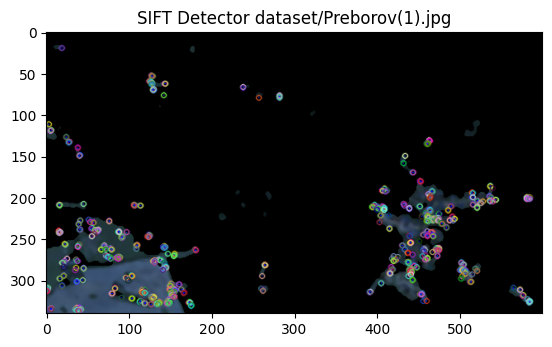

The number of descriptors in the first image: 266
The number of descriptors in the second image: 311
The number of matches: 100
Percentage of identity: 37.594%
Confidence percentage: 100%
Conclusion: the objects are identical


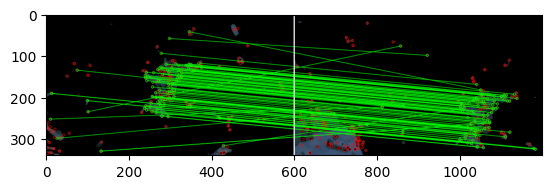

In [2]:
image_name = 'dataset/Preborov.jpg'
identifier = ImageIdentifier(image_name)

identifier.show_all([5, 15, 5], [30, 175, 125])
print("Image comparison")
identifier.feature_matching_sift('dataset/Preborov(1).jpg')

Image comparison


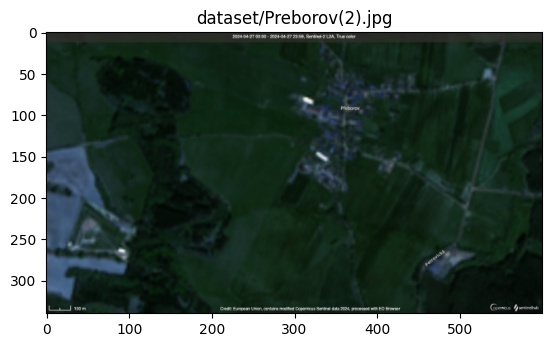

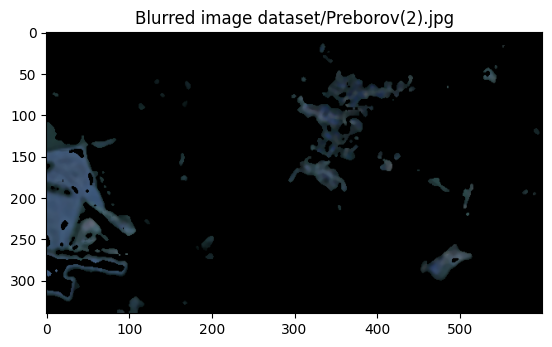

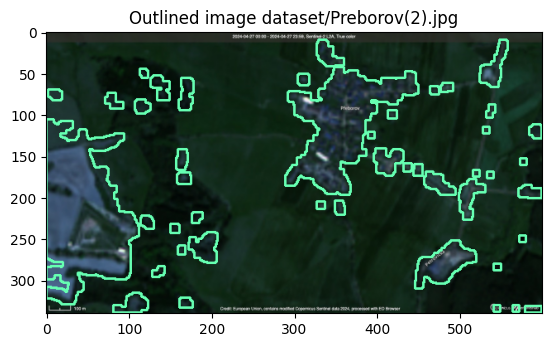

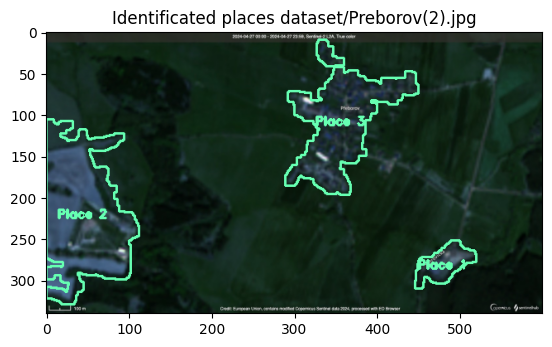

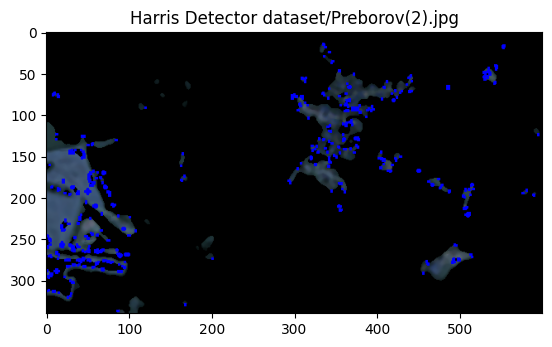

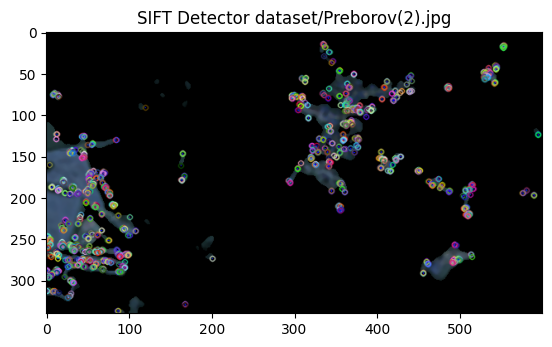

The number of descriptors in the first image: 266
The number of descriptors in the second image: 404
The number of matches: 112
Percentage of identity: 42.105%
Confidence percentage: 100%
Conclusion: the objects are identical


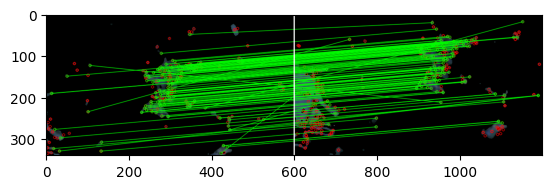

In [3]:
print("Image comparison")
identifier.feature_matching_sift('dataset/Preborov(2).jpg')

Image comparison


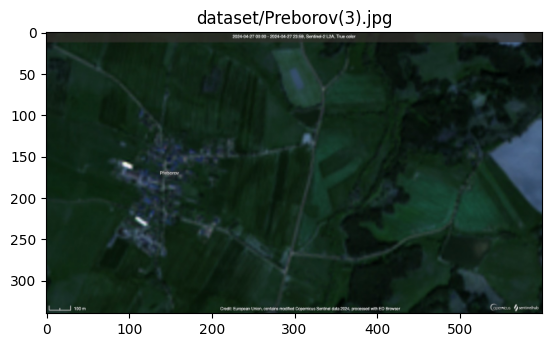

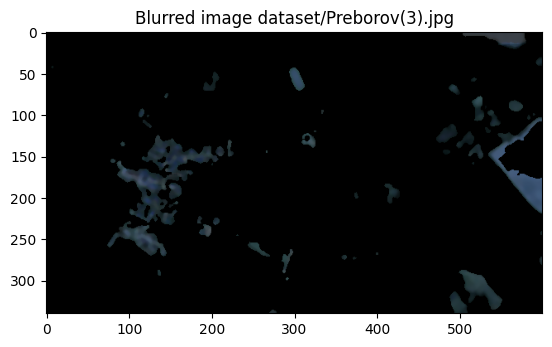

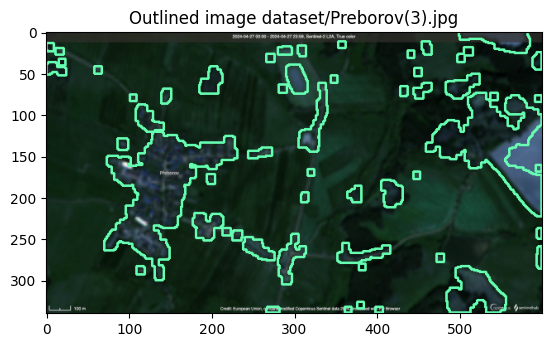

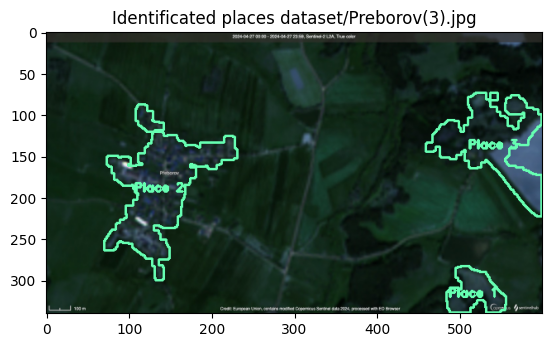

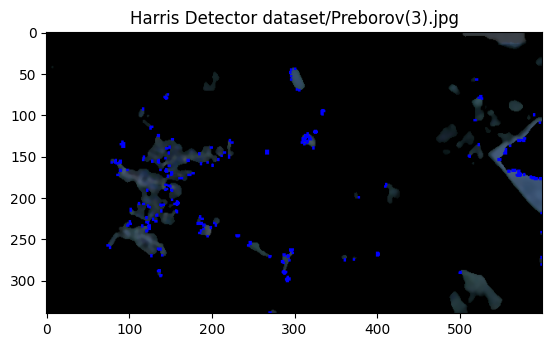

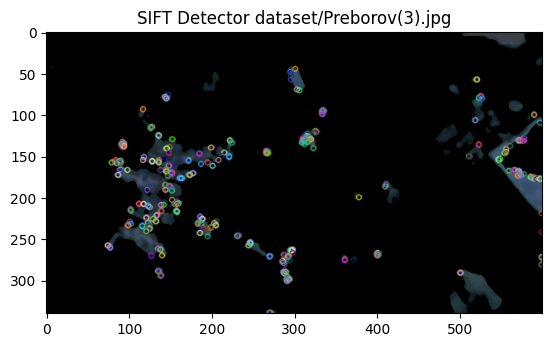

The number of descriptors in the first image: 266
The number of descriptors in the second image: 308
The number of matches: 100
Percentage of identity: 37.594%
Confidence percentage: 100%
Conclusion: the objects are identical


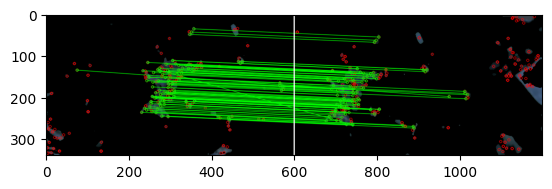

In [4]:
print("Image comparison")
identifier.feature_matching_sift('dataset/Preborov(3).jpg')

Image comparison


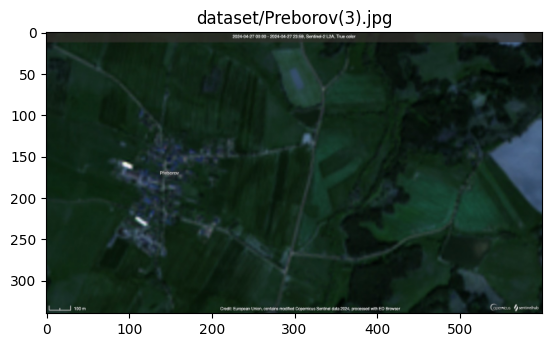

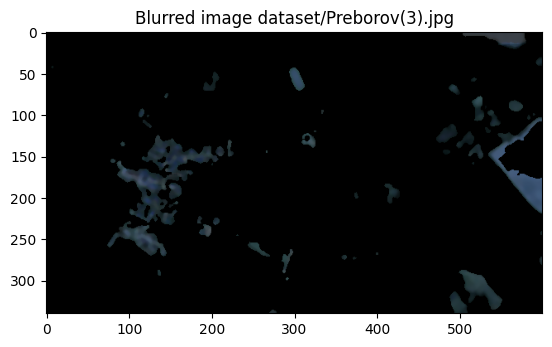

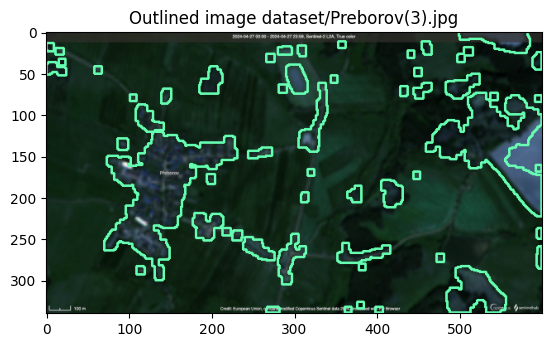

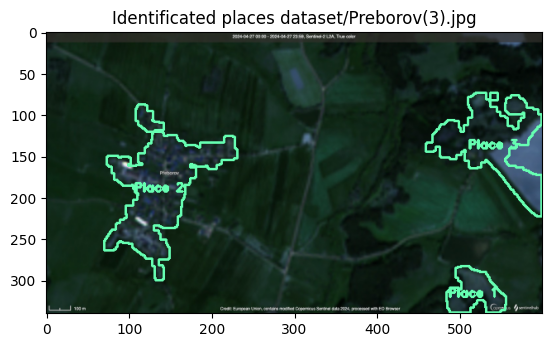

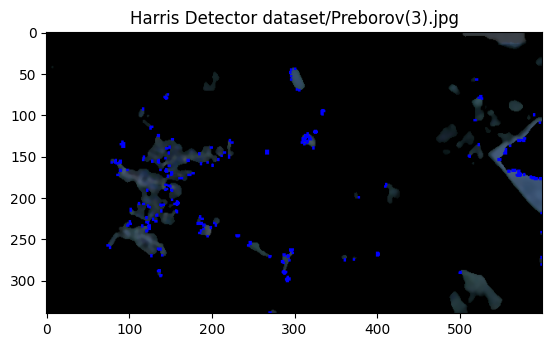

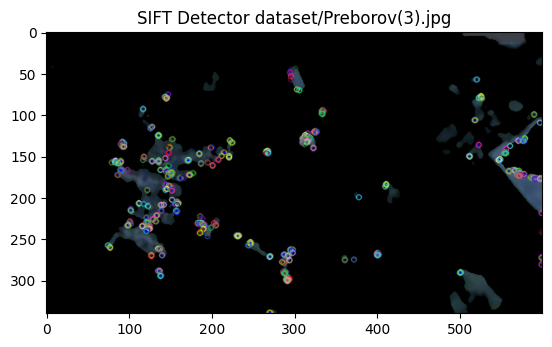

The number of descriptors in the first image: 266
The number of descriptors in the second image: 308
The number of matches: 99
Percentage of identity: 37.218%
Confidence percentage: 100%
Conclusion: the objects are identical


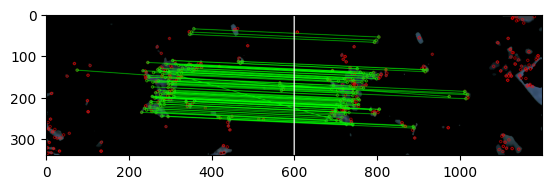

In [5]:
print("Image comparison")
identifier.feature_matching_sift('dataset/Preborov(3).jpg')

Image comparison


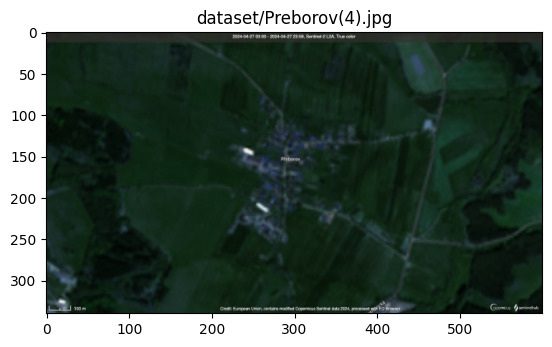

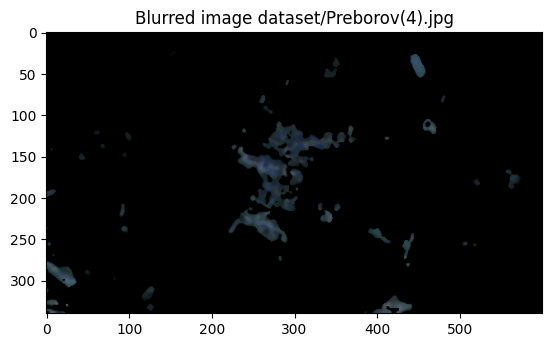

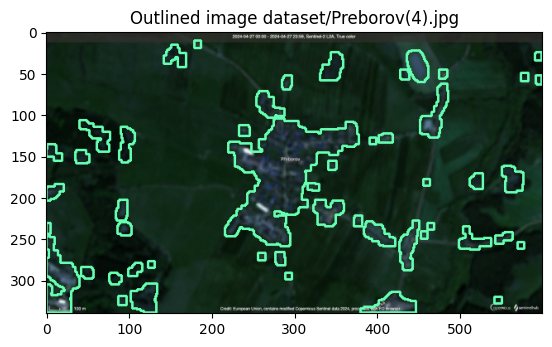

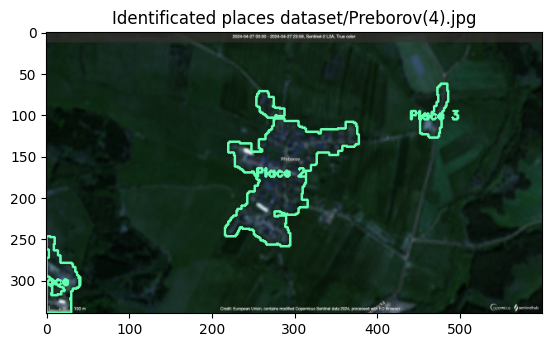

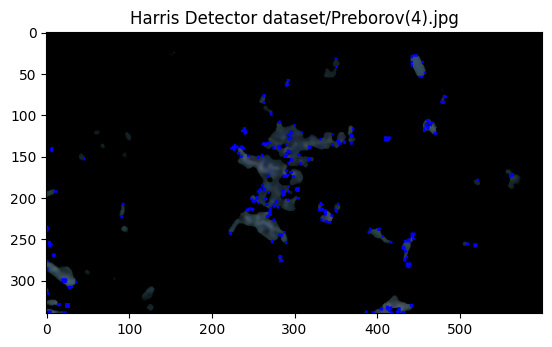

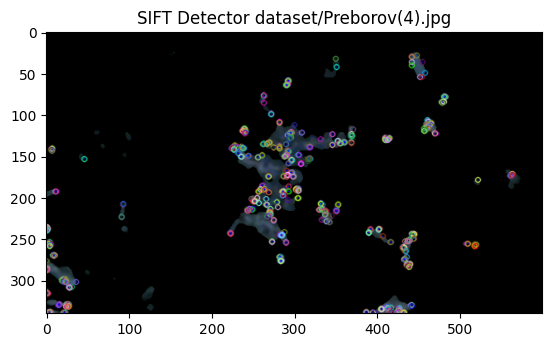

The number of descriptors in the first image: 266
The number of descriptors in the second image: 245
The number of matches: 108
Percentage of identity: 44.082%
Confidence percentage: 100%
Conclusion: the objects are identical


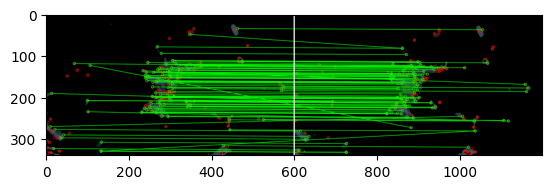

In [6]:
print("Image comparison")
identifier.feature_matching_sift('dataset/Preborov(4).jpg')

Image comparison


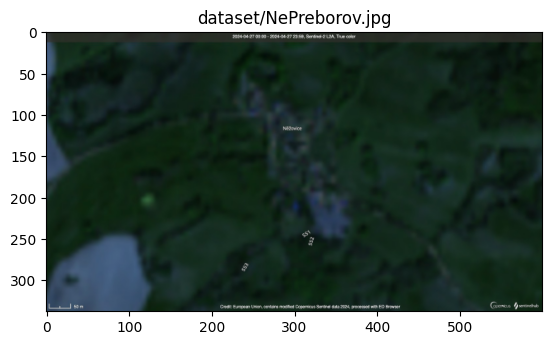

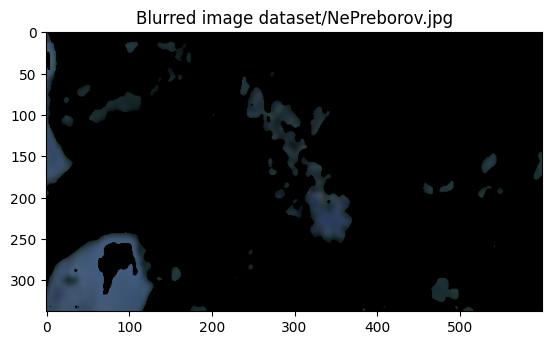

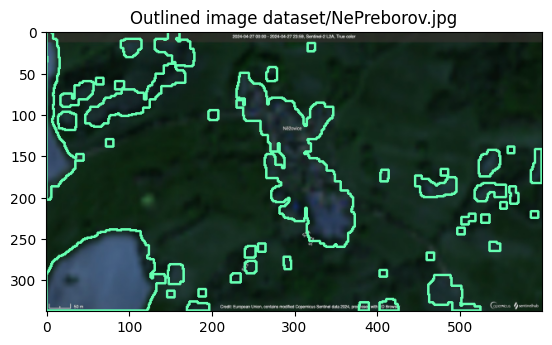

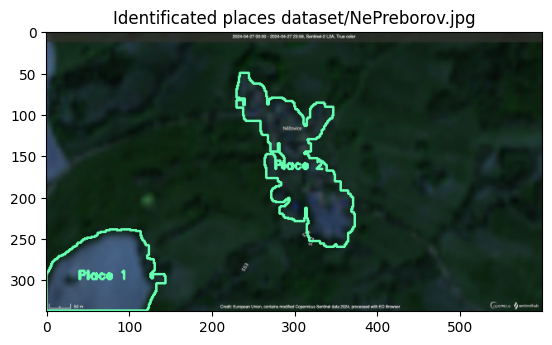

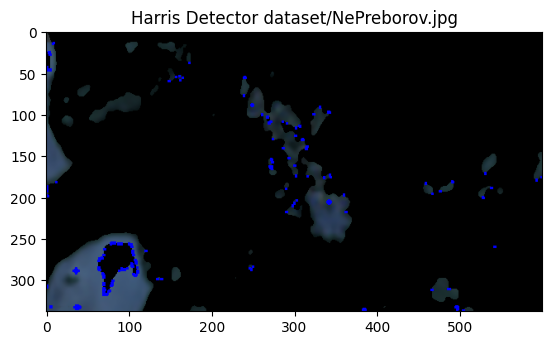

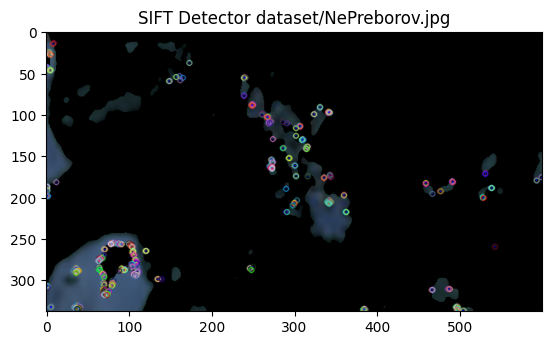

The number of descriptors in the first image: 266
The number of descriptors in the second image: 203
The number of matches: 8
Percentage of identity: 3.941%
Confidence percentage: 26.273%
Objects are not identical


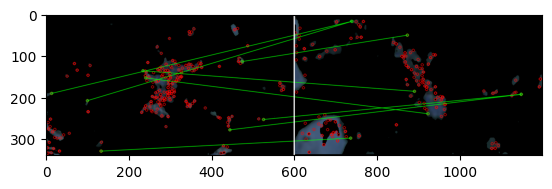

In [7]:
print("Image comparison")
identifier.feature_matching_sift('dataset/NePreborov.jpg')